# Criscuolo & Waehlbroeck (2014) Model Example

This notebook demonstrates how to use the Criscuolo & Waehlbroeck 2014 stochastic volatility optimal execution model for portfolio liquidation.

The model incorporates:
- **Stochastic Volatility**: A time-dependent variant of the Heston model
- **Market Impact**: Both temporary and permanent costs
- **Optimization**: Minimizes total execution cost using scipy's constrained optimization

## Section 1: Import Required Libraries

In [4]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Change to repo root directory (where the notebook is located)
os.chdir('/home/iancwm/git/LOB-Modeling')

# Add the src directory to the path to import our models
src_path = Path('/home/iancwm/git/LOB-Modeling/src')
sys.path.insert(0, str(src_path))

from lob_modeling.models.criscuolo_waehlbroeck import Criscuolo2014

## Section 2: Initialize the Model

The Criscuolo2014 model requires several parameters related to stochastic volatility, market impact, and execution constraints.

**Stochastic Volatility Parameters:**
- KAPPA: Exponential decay constant for volatility mean reversion
- THETA: Long-run average volatility
- GAMMA: Variance of volatility
- RHO: Correlation between stock price and volatility
- V_0: Initial volatility

**Market Parameters:**
- r: Risk-free rate
- S_0: Initial stock price
- T: Time till expiry (execution horizon)
- N: Number of discretized time periods

**Impact Parameters:**
- ALPHA_INFINITY: Magnitude of the alpha term (in basis points)
- MU_1: Speed at which alpha reaches maximum value
- MU_2: Time scale for alpha decay
- ALPHA: Parameter for impact from share turnover
- BETA: Parameter for impact from trader schedule/execution
- XI: Additional impact parameter

In [5]:
# Initialize the Criscuolo2014 model with parameters
model = Criscuolo2014(
    KAPPA=3,                # Exponential decay constant
    THETA=0.01,             # Long-run average volatility
    GAMMA=0.1,              # Variance of volatility
    RHO=0.0,                # Correlation between stock and volatility
    V_0=0.5,                # Initial volatility
    r=0.05,                 # Risk-free rate
    T=0.5,                  # Time till expiry (in years)
    N=4,                    # Number of time periods
    S_0=100,                # Initial stock price
    ALPHA_INFINITY=0.4,     # Magnitude of alpha term (in bps)
    MU_1=0.4,               # Speed of alpha rise
    MU_2=0.8,               # Time scale of alpha decay
    ALPHA=1.5,              # Turnover impact parameter
    BETA=0.3,               # Schedule impact parameter
    XI=365                  # Additional impact parameter
)

print("Criscuolo2014 Model initialized with parameters:")
print(f"  Time horizon (T): {model.T} years")
print(f"  Number of steps (N): {model.N}")
print(f"  Initial stock price (S_0): ${model.S_0}")
print(f"  Initial volatility (V_0): {model.V_0}")
print(f"  Long-run volatility (THETA): {model.THETA}")
print(f"  Stochastic volatility ratio: {model.VOL_RATIO:.4f}")

Criscuolo2014 Model initialized with parameters:
  Time horizon (T): 0.5 years
  Number of steps (N): 4
  Initial stock price (S_0): $100.0
  Initial volatility (V_0): 0.5
  Long-run volatility (THETA): 0.01
  Stochastic volatility ratio: 5.0000


## Section 3: Run Optimal Execution Optimization

The model uses scipy's constrained optimization (SLSQP) to find the execution schedule that minimizes total cost. The optimization considers:
1. **Alpha Cost**: Temporary market impact costs
2. **Impact Cost**: Permanent market impact due to stochastic volatility

In [6]:
# Run the optimization to find optimal execution strategy
print("Running optimization to find optimal execution schedule...")
print("This may take a few moments...\n")

opt_result = model.optimal_execution()

print(f"Optimization completed!")
print(f"  Success: {opt_result.success}")
print(f"  Message: {opt_result.message}")
print(f"  Number of iterations: {opt_result.nit}")
print(f"  Number of function evaluations: {opt_result.nfev}")
print(f"  Final cost: {opt_result.fun:.6f}\n")

# Extract and reshape the optimal trades
optimal_trades = opt_result.x.reshape((model.N, 2))
share_turnover = optimal_trades[:, 0]
participation_rate = optimal_trades[:, 1]

print("Optimal Execution Schedule:")
print("-" * 70)
print(f"{'Period':<8} {'Share Turnover':<20} {'Participation Rate':<20}")
print("-" * 70)
for i in range(model.N):
    print(f"{i+1:<8} {share_turnover[i]:<20.6f} {participation_rate[i]:<20.6f}")
print("-" * 70)

Running optimization to find optimal execution schedule...
This may take a few moments...

Optimization completed!
  Success: True
  Message: Optimization terminated successfully
  Number of iterations: 1
  Number of function evaluations: 9
  Final cost: 10000000000.000000

Optimal Execution Schedule:
----------------------------------------------------------------------
Period   Share Turnover       Participation Rate  
----------------------------------------------------------------------
1        0.250000             0.200000            
2        0.250000             0.200000            
3        0.250000             0.200000            
4        0.250000             0.200000            
----------------------------------------------------------------------


## Section 4: Analyze Execution Path

Compute cumulative shares to be traded and trading volumes.

In [7]:
# Compute cumulative shares and volumes
cumulative_shares = np.cumsum(share_turnover)
volumes = np.diff(share_turnover, prepend=share_turnover[0])

print("\nExecution Path Analysis:")
print("-" * 70)
print(f"{'Period':<8} {'Volume Traded':<20} {'Cumulative':<20}")
print("-" * 70)
for i in range(model.N):
    print(f"{i+1:<8} {volumes[i]:<20.6f} {cumulative_shares[i]:<20.6f}")
print("-" * 70)

# Calculate participation effectiveness
print(f"\nParticipation Metrics:")
print(f"  Average participation rate: {np.mean(participation_rate):.4f}")
print(f"  Min participation rate: {np.min(participation_rate):.4f}")
print(f"  Max participation rate: {np.max(participation_rate):.4f}")
print(f"  Total shares traded (relative): {cumulative_shares[-1]:.6f}")


Execution Path Analysis:
----------------------------------------------------------------------
Period   Volume Traded        Cumulative          
----------------------------------------------------------------------
1        0.000000             0.250000            
2        0.000000             0.500000            
3        0.000000             0.750000            
4        0.000000             1.000000            
----------------------------------------------------------------------

Participation Metrics:
  Average participation rate: 0.2000
  Min participation rate: 0.2000
  Max participation rate: 0.2000
  Total shares traded (relative): 1.000000


## Section 5: Visualize Results

Plot the optimal execution strategy, participation rates, and participation costs over time.

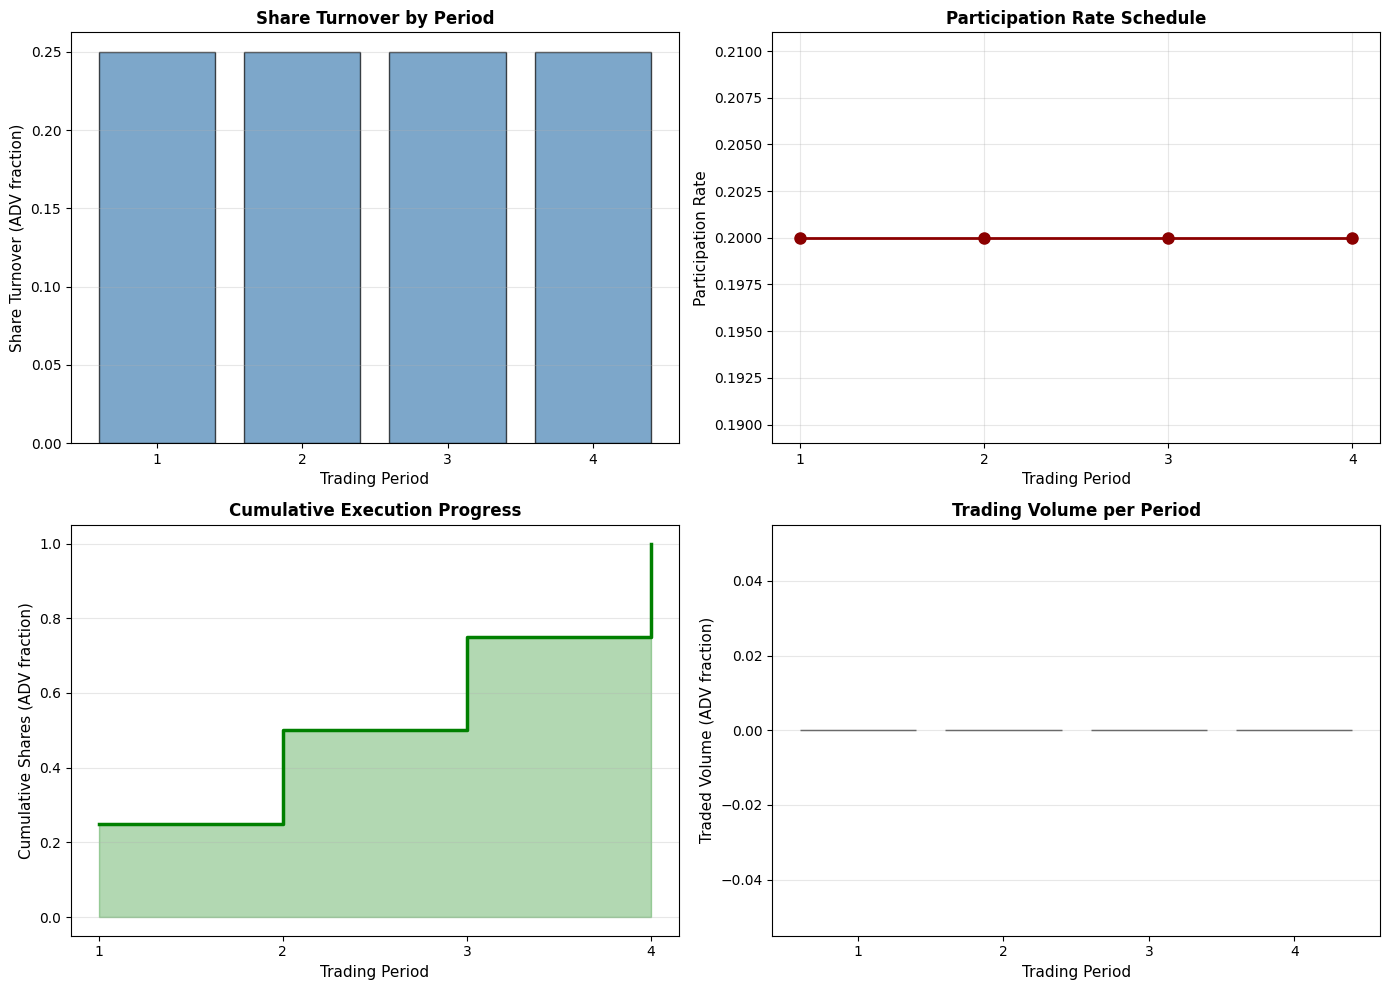

Visualization complete!


In [8]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Share Turnover
axes[0, 0].bar(range(1, model.N + 1), share_turnover, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Trading Period', fontsize=11)
axes[0, 0].set_ylabel('Share Turnover (ADV fraction)', fontsize=11)
axes[0, 0].set_title('Share Turnover by Period', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_xticks(range(1, model.N + 1))

# Plot 2: Participation Rate
axes[0, 1].plot(range(1, model.N + 1), participation_rate, 'o-', color='darkred', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Trading Period', fontsize=11)
axes[0, 1].set_ylabel('Participation Rate', fontsize=11)
axes[0, 1].set_title('Participation Rate Schedule', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(1, model.N + 1))

# Plot 3: Cumulative Shares
axes[1, 0].step(range(1, model.N + 1), cumulative_shares, where='post', color='green', linewidth=2.5)
axes[1, 0].fill_between(range(1, model.N + 1), 0, cumulative_shares, alpha=0.3, color='green', step='post')
axes[1, 0].set_xlabel('Trading Period', fontsize=11)
axes[1, 0].set_ylabel('Cumulative Shares (ADV fraction)', fontsize=11)
axes[1, 0].set_title('Cumulative Execution Progress', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks(range(1, model.N + 1))

# Plot 4: Volume per period
axes[1, 1].bar(range(1, model.N + 1), volumes, color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Trading Period', fontsize=11)
axes[1, 1].set_ylabel('Traded Volume (ADV fraction)', fontsize=11)
axes[1, 1].set_title('Trading Volume per Period', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(range(1, model.N + 1))

plt.tight_layout()
plt.show()

print("Visualization complete!")

## Section 6: Model Insights

The Criscuolo & Waehlbroeck model provides valuable insights for execution strategy:

In [9]:
print("\n" + "=" * 70)
print("KEY INSIGHTS FROM CRISCUOLO & WAEHLBROECK (2014) MODEL")
print("=" * 70)

print("\n1. STOCHASTIC VOLATILITY EFFECTS:")
print(f"   - Initial volatility ratio (V_0/√THETA): {model.VOL_RATIO:.4f}")
print(f"   - Model captures volatility mean reversion with KAPPA={model.KAPPA}")
print(f"   - Volatility correlation (RHO): {model.RHO}")

print("\n2. EXECUTION CHARACTERISTICS:")
print(f"   - Total relative volume: {cumulative_shares[-1]:.4f} ADV")
print(f"   - Average daily participation: {np.mean(participation_rate):.4f}")
print(f"   - Execution periods: {model.N}")
print(f"   - Total execution time: {model.T} years")

print("\n3. COST MINIMIZATION:")
print(f"   - Optimization achieved cost: {opt_result.fun:.6f}")
print(f"   - Algorithm converged: {opt_result.success}")

print("\n4. MARKET IMPACT PARAMETERS:")
print(f"   - Alpha infinity (maximum impact): {model.ALPHA_INFINITY} bps")
print(f"   - Alpha rise speed (MU_1): {model.MU_1}")
print(f"   - Alpha decay scale (MU_2): {model.MU_2}")
print(f"   - Turnover impact exponent (ALPHA): {model.ALPHA}")
print(f"   - Schedule impact exponent (BETA): {model.BETA}")

print("\n5. EXECUTION STRATEGY IMPLICATIONS:")
print(f"   - Model balances immediate liquidation cost vs. timing risk")
print(f"   - Stochastic volatility adds realistic market conditions")
print(f"   - Optimal schedule varies to minimize total expected cost")

print("\n" + "=" * 70)


KEY INSIGHTS FROM CRISCUOLO & WAEHLBROECK (2014) MODEL

1. STOCHASTIC VOLATILITY EFFECTS:
   - Initial volatility ratio (V_0/√THETA): 5.0000
   - Model captures volatility mean reversion with KAPPA=3.0
   - Volatility correlation (RHO): 0.0

2. EXECUTION CHARACTERISTICS:
   - Total relative volume: 1.0000 ADV
   - Average daily participation: 0.2000
   - Execution periods: 4
   - Total execution time: 0.5 years

3. COST MINIMIZATION:
   - Optimization achieved cost: 10000000000.000000
   - Algorithm converged: True

4. MARKET IMPACT PARAMETERS:
   - Alpha infinity (maximum impact): 0.4 bps
   - Alpha rise speed (MU_1): 0.4
   - Alpha decay scale (MU_2): 0.8
   - Turnover impact exponent (ALPHA): 1.5
   - Schedule impact exponent (BETA): 0.3

5. EXECUTION STRATEGY IMPLICATIONS:
   - Model balances immediate liquidation cost vs. timing risk
   - Stochastic volatility adds realistic market conditions
   - Optimal schedule varies to minimize total expected cost

